We begin by plotting a theoretical signal and normalizing it between 0 and 1:

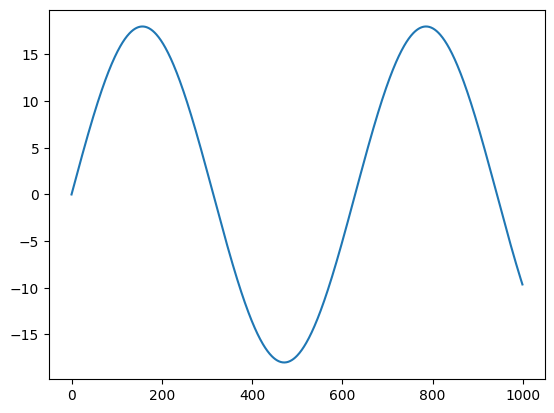

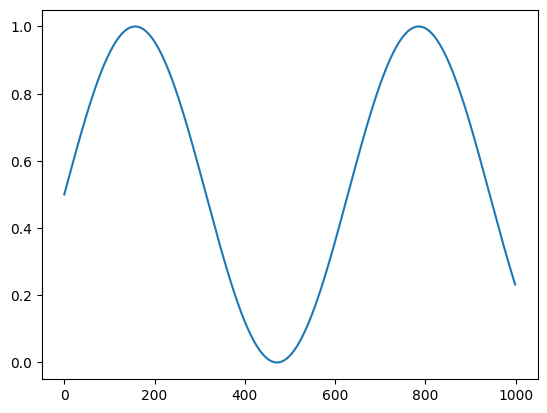

0.0
1.0


In [83]:
import numpy as np
import matplotlib.pyplot as plt

step = 0.01
x = np.arange(0, 10, step)

y = np.sin(x)*18

def normalize_array(arr, low=0, high=1):
    norm_arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * (high-low)
    return norm_arr + low

plt.plot(y)
plt.show()

signal = normalize_array(y)

plt.plot(signal)
plt.show()

print(np.min(signal))
print(np.max(signal))

We then generate a signal corresponding to what might look like movement spikes:

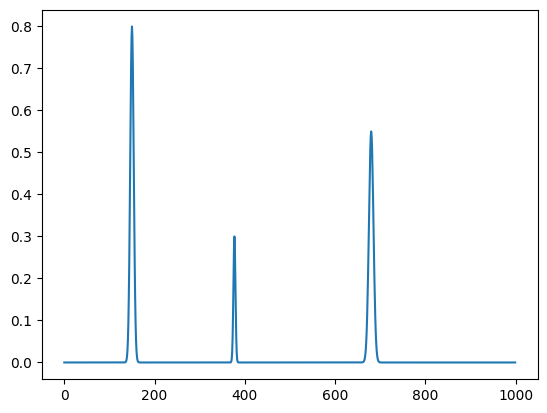

In [84]:
heights = [0.8, 0.3, 0.55]
widths = [0.003, 0.001, 0.005]
locs = [150, 377, 680]

#############

spikes = []
for i in range(len(heights)):
    spike = heights[i] * np.exp(-(1/widths[i]) * (x - (locs[i]*step))**2)
    spikes.append(spike)

movement = sum(spikes)

plt.plot(movement)
plt.show()

The original signal is modified with the movement spikes:

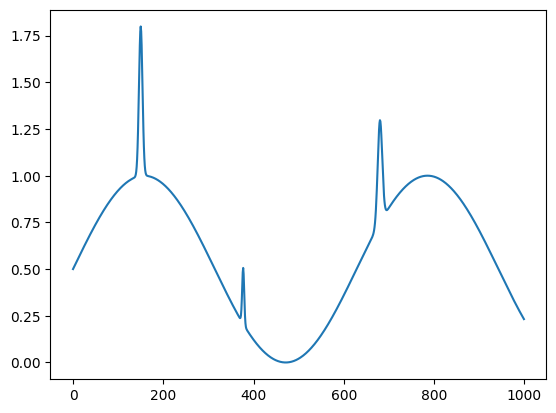

In [85]:
signal_w_movement = signal + movement

plt.plot(signal_w_movement)
plt.show()

Then we add *distinct* noise to both the movement spikes and to the signal with movement. The noisy movement spikes represents the signal we are trying to regress out (what we might obtain by taking the outside of the cranial window, for instance), whereas the noisy signal with movement represents the signal we are trying to denoise (for instance our GCaMP or HbT signals).

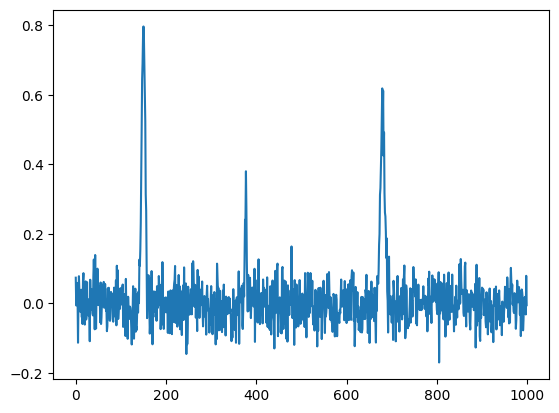

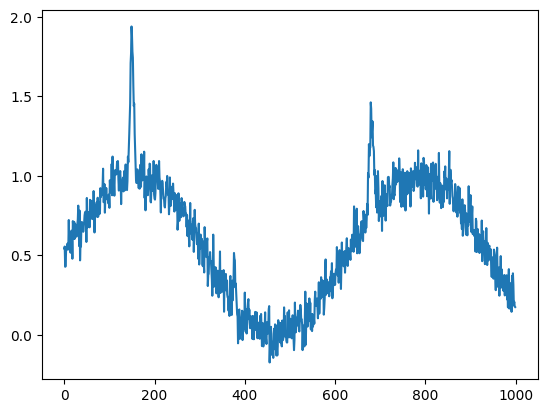

In [86]:
noisy_movement = movement + np.random.normal(scale=0.05, size=signal.shape)

noisy_signal_w_movement = signal_w_movement + np.random.normal(scale=0.08, size=signal.shape)

plt.plot(noisy_movement)
plt.show()

plt.plot(noisy_signal_w_movement)
plt.show()

Finally we will try to regress the noisy movement out of the noisy signal with movement. Hopefully, this should give us something relatively close to the original, non-noisy signal without movement.

In [87]:
import numpy as np
from scipy.stats import linregress

result = linregress(noisy_movement, noisy_signal_w_movement, alternative="two-sided")

print(result.slope)

1.2056653567180886


For:

$$y(t)=a\cdot x(t) + \epsilon(t)$$

Where $y(t)$ is the noisy signal, $a$ is the slope of the regression, $x(t)$ is the noise to regress out, and $\epsilon(t)$ is the residue (which corresponds to the "clean" signal). We are looking for:

$$\epsilon(t)=y(t) - a\cdot x(t)$$

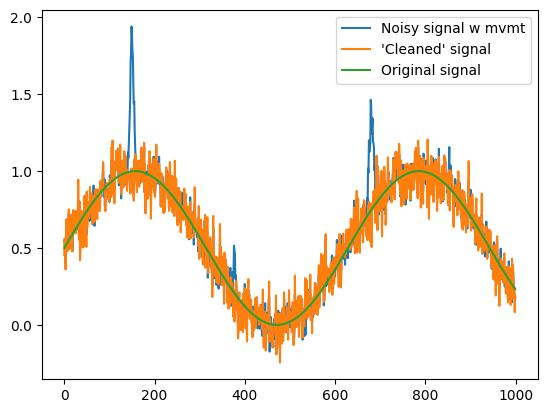

In [88]:
clean_signal = noisy_signal_w_movement - result.slope * noisy_movement

plt.plot(noisy_signal_w_movement, label="Noisy signal w mvmt")
plt.plot(clean_signal, label="'Cleaned' signal")
plt.plot(signal, label="Original signal")
plt.legend()
plt.show()

As we can see the baseline noise is still there, but the movement spikes are reduced in magnitude. As we can see, the result doesn't improve that much even we have a perfect movement signal, in fact we even see an over-correction:

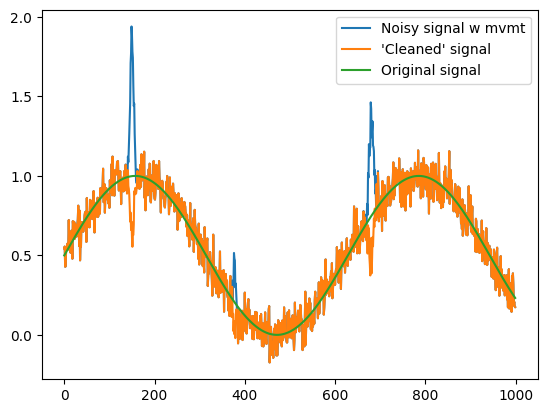

In [89]:
result = linregress(movement, noisy_signal_w_movement, alternative="two-sided")

clean_signal = noisy_signal_w_movement - result.slope * movement

plt.plot(noisy_signal_w_movement, label="Noisy signal w mvmt")
plt.plot(clean_signal, label="'Cleaned' signal")
plt.plot(signal, label="Original signal")
plt.legend()
plt.show()

Here we were working with a single array for our each signal (noisy_signal_w_movement and noisy_movement). In practice, when trying to regress out movement from our data, we are going to be working with the following:

- A 1d array for the noisy movement. Usually this will be something like the average of the outside of the cranial window, where there is theoretically no GCaMP/hemodynamic signal but we can still observe the movement spikes.

- A 3d array for the noisy signal with movement. This will be the cranial window ROI with each pixel corresponding to a single 1d array of noisy signal with movement. We will need to loop through all the pixels, do the linear regression for **each** pixel, and apply the regress out the movement individually as well.

Let us try it:

In [90]:
from toolbox_jocha.hdf5 import get_data_from_dataset

mouse_num = "39-12"
filepath = f"D:/mouse_data/new_data/M{mouse_num}/formatted/M{mouse_num}_v1_mvmt.h5"

signal_str = "GCaMP"
noisy_signal, _ = get_data_from_dataset(filepath, f"data/3d/{signal_str}")
noisy_mvmt, _ = get_data_from_dataset(filepath, "data/3d/GCaMP_mvmt")

# Average the outside of the cranial window to a 1d array
noisy_mvmt = np.nanmean(noisy_mvmt, axis=(1,2))

print(noisy_signal.shape)
print(noisy_mvmt.shape)

(900, 238, 239)
(900,)


Time elapsed: 5.171
Average slope: 13.038808856631338


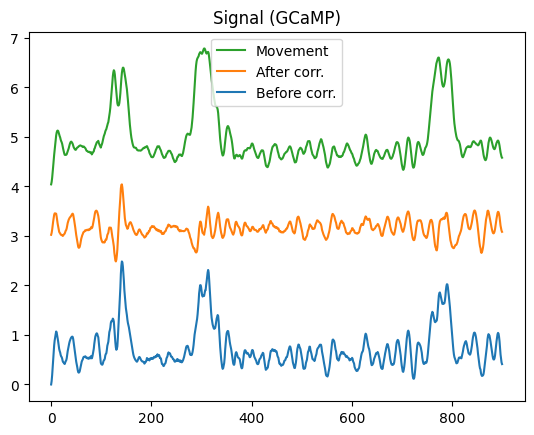

In [91]:
import time
from toolbox_jocha.other import y_offset_signals

clean_signal = np.zeros_like(noisy_signal) * np.nan
slopes = []
roll_val = 0
limits = (0, 1440)

t0 = time.time()

noisy_mvmt = np.roll(noisy_mvmt, roll_val)

for row in range(noisy_signal.shape[1]):
    for col in range(noisy_signal.shape[2]):

        if np.isnan(noisy_signal[0,row,col]):
            continue

        else:
            result = linregress(noisy_mvmt, noisy_signal[:,row,col], alternative="two-sided")
            clean_signal[:,row,col] = noisy_signal[:,row,col] - result.slope * noisy_mvmt
            slopes.append(result.slope)

t1 = time.time()

# print(np.allclose(clean_signal, noisy_signal))


print(f"Time elapsed: {(t1-t0):.3f}")

print(f"Average slope: {np.mean(slopes)}")

to_plot = y_offset_signals([np.nanmean(noisy_signal, axis=(1,2)), np.nanmean(clean_signal, axis=(1,2)), noisy_mvmt*20], maximize=False)
plt.plot(to_plot[0], label="Before corr.")
plt.plot(to_plot[1], label="After corr.")
plt.plot(to_plot[2], label="Movement")
plt.title(f"Signal ({signal_str})")
plt.legend(reverse=True)
plt.show()

# plt.plot(np.nanmean(noisy_signal, axis=(1,2)))
# plt.title("Signal (GCaMP) before movement removal")
# plt.show()

# plt.plot(np.nanmean(clean_signal, axis=(1,2)))
# plt.title("Signal (GCaMP) after movement removal")
# plt.show()

# plt.plot(noisy_mvmt)
# plt.title("Movement")
# plt.show()


# plt.plot(noisy_signal[:, 100, 34])
# plt.show()



# plt.plot(clean_signal[:, 100, 34])
# plt.show()

We can try this with a single GCaMP timeseries (one pixel) to see what happens:

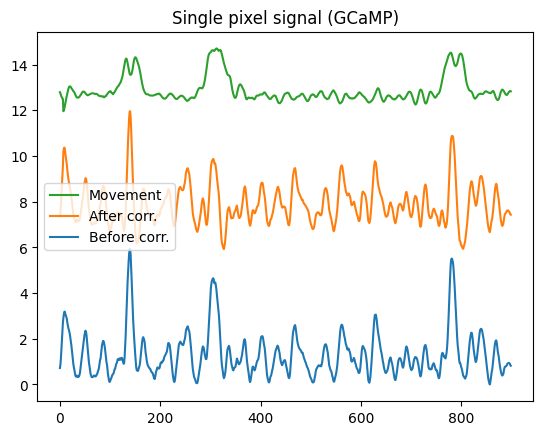

In [92]:
from toolbox_jocha.hdf5 import get_data_from_dataset
from toolbox_jocha.other import y_offset_signals

# mouse_num = "322-6"
filepath = f"D:/mouse_data/new_data/M{mouse_num}/formatted/M{mouse_num}_v1_mvmt.h5"

noisy_signal, _ = get_data_from_dataset(filepath, f"data/3d/{signal_str}")
noisy_mvmt, _ = get_data_from_dataset(filepath, "data/3d/GCaMP_mvmt")

roll_val = 7

# Average the outside of the cranial window to a 1d array
noisy_mvmt = np.nanmean(noisy_mvmt, axis=(1,2))
noisy_mvmt = np.roll(noisy_mvmt, roll_val)

# Select a single pixel
noisy_signal = noisy_signal[:,100,50]

result = linregress(noisy_mvmt, noisy_signal, alternative="two-sided")
clean_signal = noisy_signal - result.slope * noisy_mvmt
mvmt = noisy_mvmt*20
to_plot = y_offset_signals([noisy_signal, clean_signal, mvmt], maximize=False)


plt.plot(to_plot[0], label="Before corr.")
plt.plot(to_plot[1], label="After corr.")
plt.plot(to_plot[2], label="Movement")
plt.title(f"Single pixel signal ({signal_str})")
plt.legend(reverse=True)
plt.show()

# plt.plot(clean_signal)
# plt.title(f"Single pixel signal ({signal_str}) after movement removal")
# plt.show()

# plt.plot(noisy_mvmt)
# plt.title("Movement signal")
# plt.show()